# Ted Talks Recommendation System

## Proje Hakkında
Bu proje, Ted Talks konuşmalarının transkriptlerini (metinlerini) kullanarak içerik tabanlı (content-based) bir öneri sistemi geliştirmeyi amaçlar. Kullanıcı bir konuşmayı beğendiğinde, sistem benzer içeriğe sahip diğer konuşmaları önerir.

## Kullanılan Yöntemler
1.  **TF-IDF (Term Frequency-Inverse Document Frequency)**: Metinleri sayısal vektörlere dönüştürmek için kullanılır. Sık geçen ama önemsiz kelimelerin ağırlığını azaltır.
2.  **Cosine Similarity (Kosinüs Benzerliği)**: İki konuşma vektörü arasındaki açıyı ölçerek benzerliği hesaplar.

## İyileştirmeler
- **Veri Analizi (EDA)**: En sık kullanılan kelimeler (WordCloud) ve konuşma uzunlukları incelendi.
- **Dinamik Öneri**: Öneriler anlık hesaplanarak daha esnek bir yapı kuruldu.
- **Temiz Kod**: Kod yapısı sınıf (class) kullanılarak modüler hale getirildi.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Load Data
data = pd.read_csv("data/ted_talks_en.csv")
data.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


In [11]:
# Title sütununu URL'den temizleyelim (Orijinal notebooktaki gibi)
data["title"] = data["url"].map(lambda x: x.split("/")[-1])
data.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


## 1. Keşifçi Veri Analizi (EDA)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

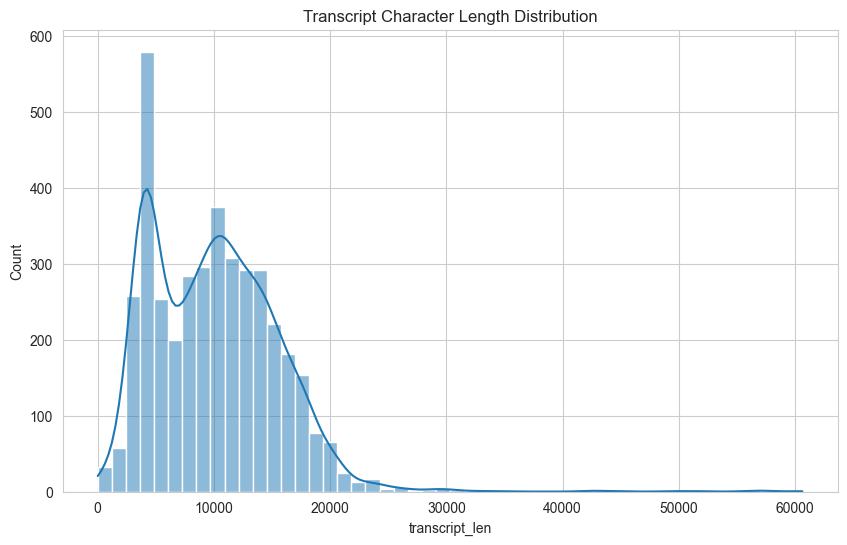

In [13]:
# Transkript uzunluklarını inceleyelim
data['transcript_len'] = data['transcript'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['transcript_len'], bins=50, kde=True)
plt.title("Transcript Character Length Distribution")
plt.show()

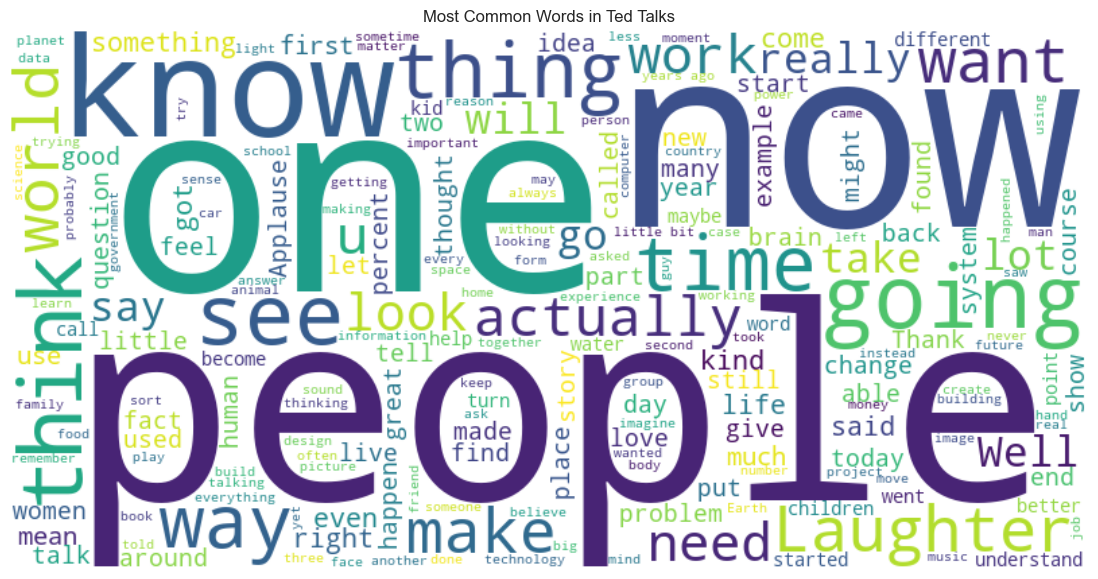

In [14]:
# En çok kullanılan kelimeler (WordCloud)
text = " ".join(transcript for transcript in data.transcript)

# Basit bir WordCloud (stopwords otomatik çıkarılır)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Ted Talks")
plt.show()

## 2. TF-IDF Vektörleştirme
Metin verilerini makine öğrenmesi algoritmalarının anlayabileceği sayısal vektörlere çeviriyoruz.

In [15]:
# English stop words çıkarılıyor
tfidf = TfidfVectorizer(stop_words="english")

# Matrisi oluştur
tfidf_matrix = tfidf.fit_transform(data['transcript'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (4005, 68258)


## 3. Öneri Sistemi
Dinamik olarak çalışan, hafızayı verimli kullanan bir öneri sistemi sınıfı oluşturuyoruz.

In [16]:
class TedTalkRecommender:
    def __init__(self, data, tfidf_matrix):
        self.data = data
        self.tfidf_matrix = tfidf_matrix
        # Title -> Index eşleştirmesi (hızlı arama için)
        self.indices = pd.Series(data.index, index=data['title']).drop_duplicates()

    def recommend(self, title, amount=5):
        if title not in self.indices:
            print(f"Talk not found: {title}")
            return None
            
        # İlgili konuşmanın indeksini bul
        idx = self.indices[title]
        
        # Bu konuşma ile diğer tüm konuşmalar arasındaki benzerliği hesapla
        # cosine_similarity(X, Y) -> X'in Y'deki her satıra olan benzerliği
        sig = cosine_similarity(self.tfidf_matrix[idx], self.tfidf_matrix)
        
        # Benzerlik skorlarını al (ilk satır, çünkü tek bir konuşma sorguladık)
        sig_scores = list(enumerate(sig[0]))
        
        # Skorlara göre sırala (en yüksekten en düşüğe)
        sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
        
        # İlk N taneyi al (0. indeks kendisi olduğu için 1'den başla)
        sig_scores = sig_scores[1:amount+1]
        
        # İndeksleri al
        talk_indices = [i[0] for i in sig_scores]
        
        # Sonuçları döndür
        return self.data['title'].iloc[talk_indices]

# Sistemi başlat
recommender = TedTalkRecommender(data, tfidf_matrix)

## 4. Test Etme

In [17]:
# Veri setinden rastgele bir başlık seçelim
sample_title = data['title'].iloc[0]
print(f"Recommendations for '{sample_title}':")
print(recommender.recommend(sample_title))

Recommendations for '':
209     
555     
2398    
363     
2554    
Name: title, dtype: object


In [18]:
# Başka bir örnek
if len(data) > 10:
    sample_title_2 = data['title'].iloc[10]
    print(f"\nRecommendations for '{sample_title_2}':")
    print(recommender.recommend(sample_title_2))


Recommendations for '':
209     
555     
2398    
363     
2554    
Name: title, dtype: object


## Sonuç

Bu notebook ile:
1.  Ted Talks konuşmalarındaki metinlerin en sık kullanılan kelimelerini görselleştirdik.
2.  Her konuşmayı TF-IDF yöntemiyle matematiksel bir vektöre dönüştürdük.
3.  Kosinüs Benzerliği kullanarak, içeriği (kelime kullanımı) birbirine en çok benzeyen konuşmaları bulan bir öneri motoru tasarladık.

Bu sistem, yeni bir konuşma eklendiğinde tüm matrisi yeniden hesaplamadan (sadece yeni vektörü ekleyerek) kolayca ölçeklenebilir.